# Capstone EDA & Baseline — Policyholder Lapse (Churn Proxy)

**Research question:** Can ML predict which policyholders are likely to lapse within 12 months and support actionable **risk tiers** for retention?

**Note**
Although the Telco Customer Churn dataset already appears in the syllabus for basic classification exercises, this project uses it in a non-standard, domain-specific way. Instead of stopping at model accuracy, I reframed churn as an insurance lapse analogue, applied threshold tuning, calibration, and risk-decile segmentation, and translated results into actionable business implications for lapse-sensitive products. This shows how even a familiar dataset can generate new insights and practical value when aligned with real industry contexts.


**The dataset file is stored at:**
```
"https://github.com/aiactuary/capstone1/raw/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"
```


In [88]:
# Imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, brier_score_loss
)
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
plt.rcParams['figure.figsize'] = (8,5)
pd.set_option('display.max_columns', 100)

## Read Data

In [90]:
url = "https://github.com/aiactuary/capstone1/raw/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("Shape:", df.shape)
df.head(3)

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Basic Structure & Info

In [92]:
rows, cols = df.shape
print(f'Rows: {rows}, Columns: {cols}')
df.info()

Rows: 7043, Columns: 21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  

## Data Cleaning

In [94]:
# Convert TotalCharges to numeric; impute blanks with MonthlyCharges
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    if 'MonthlyCharges' in df.columns:
        df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

# Drop duplicate customers by ID (if any)
if 'customerID' in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset=['customerID'])
    print('Removed duplicates:', before - len(df))

# Standardize target (Yes/No)
df['Churn'] = df['Churn'].astype(str).str.strip().str.title()  # 'Yes'/'No'

Removed duplicates: 0


## Target Distribution

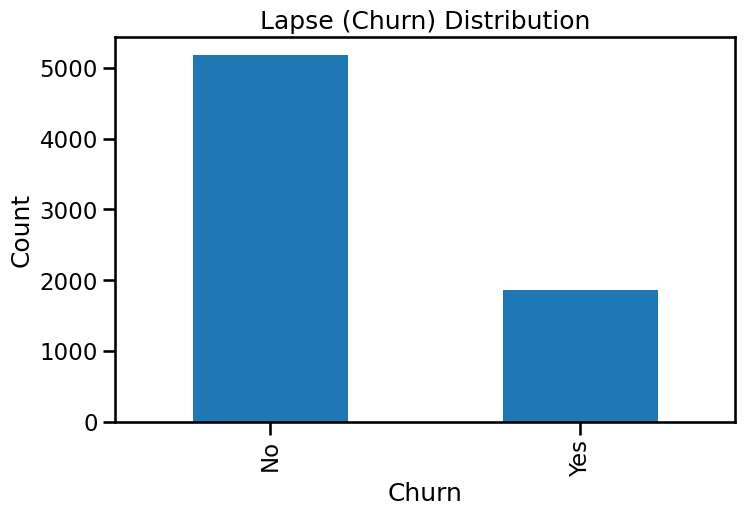

Churn rate: 0.2654


In [96]:
y = (df['Churn'] == 'Yes').astype(int)
ax = y.value_counts().sort_index().plot(kind='bar')
ax.set_xticklabels(['No','Yes'])
ax.set_title('Lapse (Churn) Distribution')
ax.set_xlabel('Churn'); ax.set_ylabel('Count')
plt.show()
print('Churn rate:', y.mean().round(4))

## Exploratory Data Analysis (EDA)

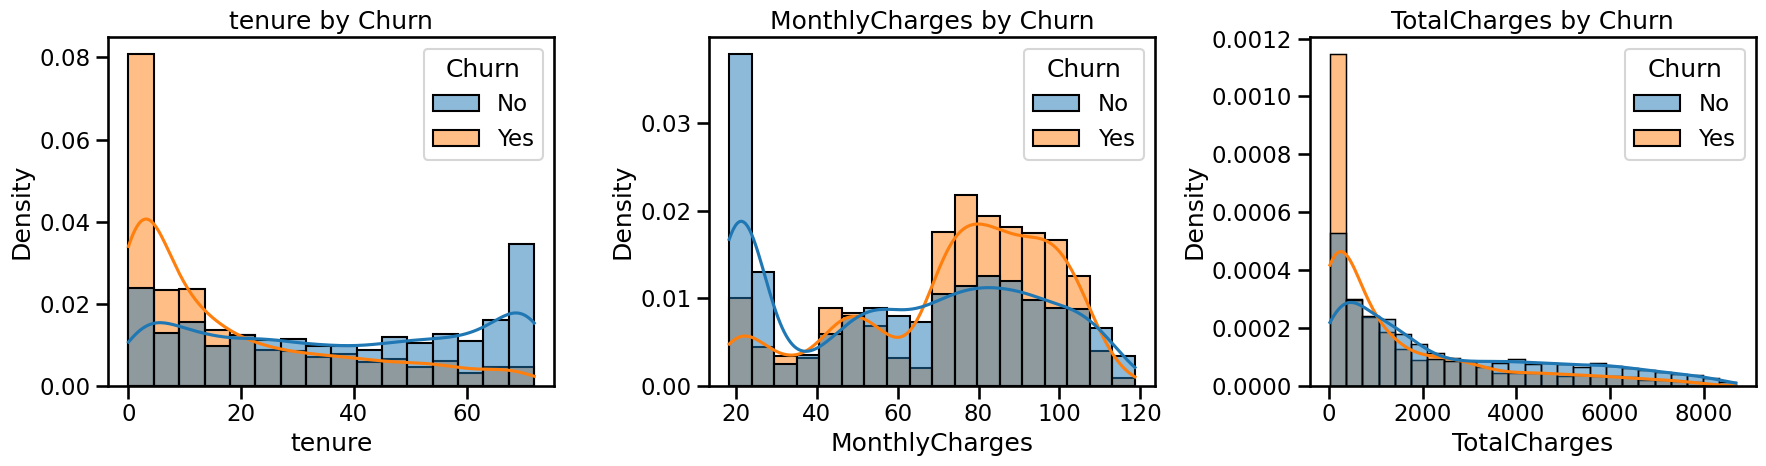

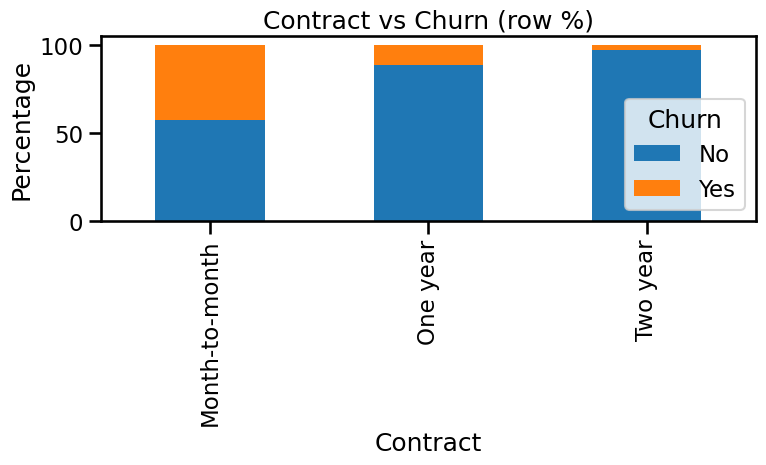

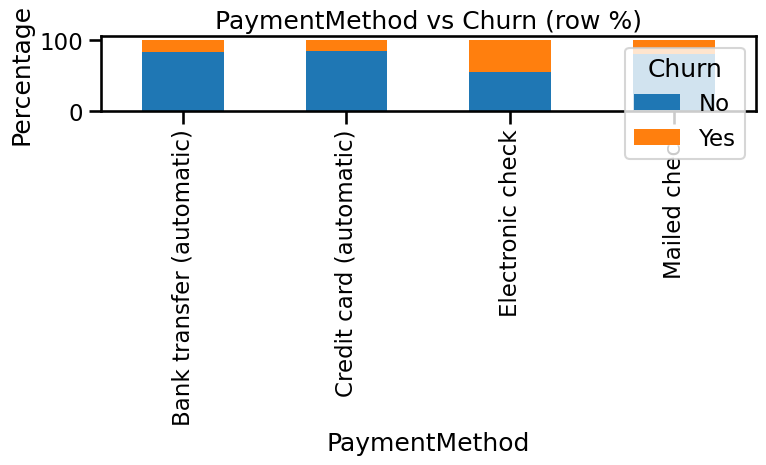

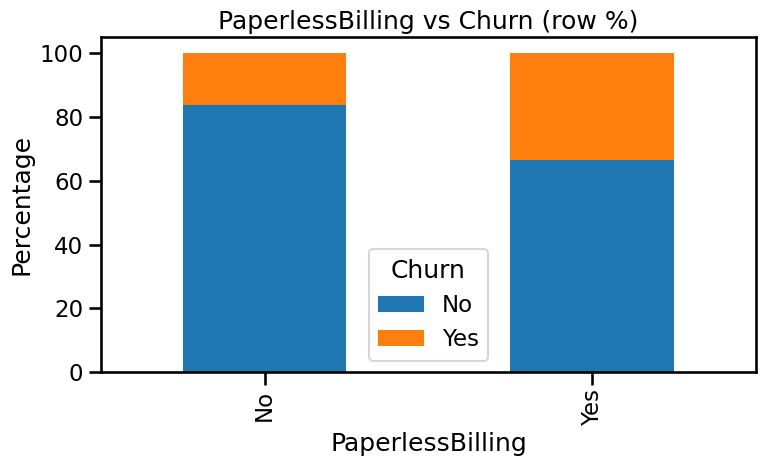

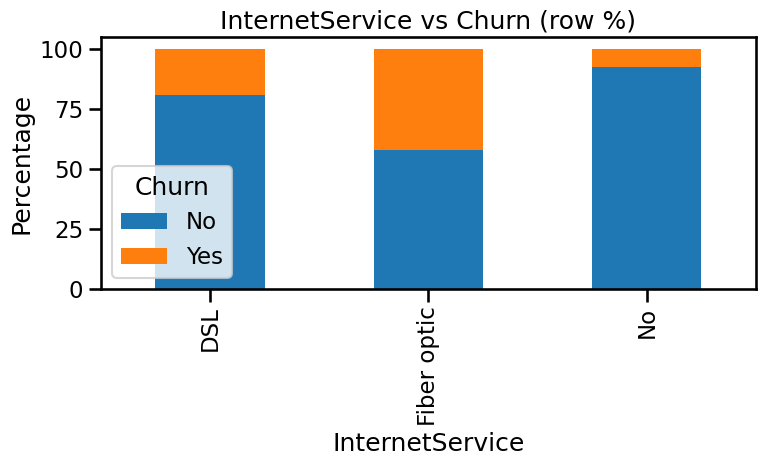

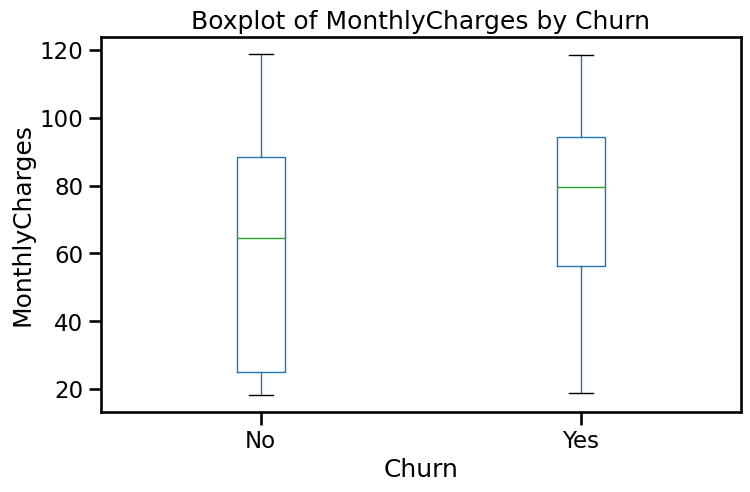

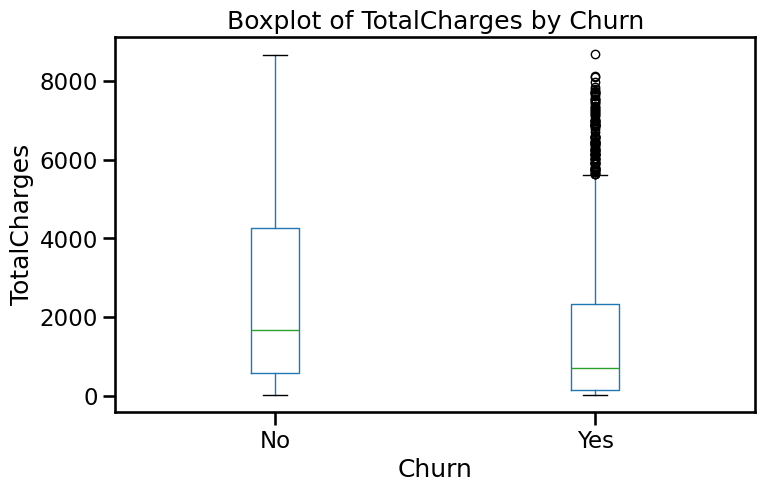

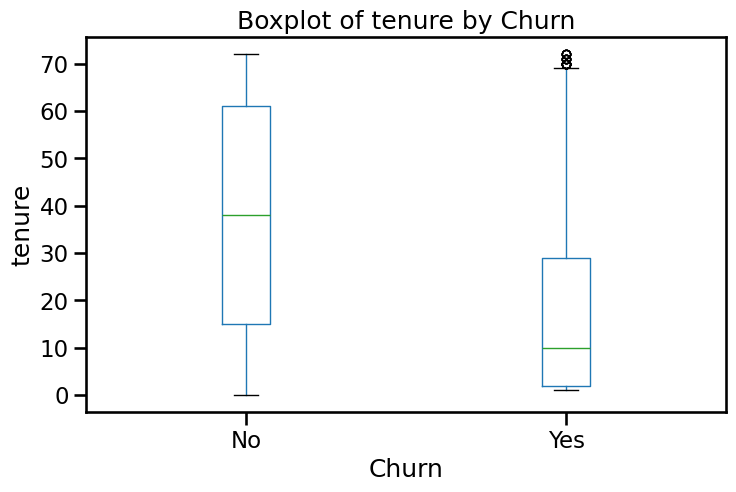

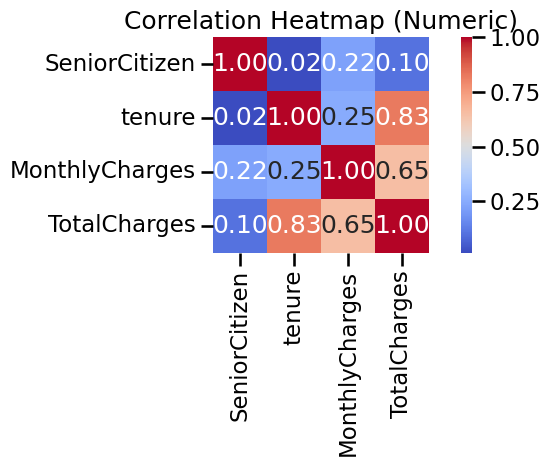

In [98]:
# Numeric distributions split by churn
num_preview = [c for c in ['tenure','MonthlyCharges','TotalCharges'] if c in df.columns]
fig, axes = plt.subplots(1, len(num_preview), figsize=(6*len(num_preview), 5))
if len(num_preview) == 1: axes = [axes]
for ax, col in zip(axes, num_preview):
    sns.histplot(data=df, x=col, hue='Churn', kde=True, stat='density', common_norm=False, ax=ax)
    ax.set_title(f'{col} by Churn')
    ax.set_xlabel(col); ax.set_ylabel('Density')
plt.tight_layout(); plt.show()

# Categorical stacked bars vs churn
for col in [c for c in ['Contract','PaymentMethod','PaperlessBilling','InternetService'] if c in df.columns]:
    ct = (pd.crosstab(df[col], df['Churn'], normalize='index')*100).round(1)
    ct.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Churn (row %)'); plt.ylabel('Percentage'); plt.legend(title='Churn')
    plt.tight_layout(); plt.show()

# Boxplots for outliers
for c in [col for col in ['MonthlyCharges','TotalCharges','tenure'] if col in df.columns]:
    df.boxplot(column=c, by='Churn', grid=False)
    plt.suptitle(''); plt.title(f'Boxplot of {c} by Churn'); plt.xlabel('Churn'); plt.ylabel(c)
    plt.show()

# Correlation heatmap (numeric)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
    plt.title('Correlation Heatmap (Numeric)')
    plt.tight_layout(); plt.show()

## Outlier Analysis (IQR & Z‑score)

In [100]:
import numpy as np

def outlier_summary(series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if len(s) == 0:
        return {'count': 0, 'iqr_outliers': 0, 'iqr_pct': 0.0, 'z_outliers': 0, 'z_pct': 0.0}
    q1, q3 = np.percentile(s, [25, 75]); iqr = q3 - q1
    iqr_low, iqr_high = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_mask = (s < iqr_low) | (s > iqr_high)
    mu, sd = s.mean(), s.std(ddof=0); z_mask = (np.abs((s - mu) / (sd if sd>0 else 1)) > 3)
    return {'count': int(s.shape[0]), 'iqr_outliers': int(iqr_mask.sum()), 'iqr_pct': float(iqr_mask.mean()*100),
            'z_outliers': int(z_mask.sum()), 'z_pct': float(z_mask.mean()*100)}
    
numeric_focus = [c for c in ['MonthlyCharges','TotalCharges','tenure'] if c in df.columns]
outlier_report = {c: outlier_summary(df[c]) for c in numeric_focus}
pd.DataFrame(outlier_report).T

,count,iqr_outliers,iqr_pct,z_outliers,z_pct
MonthlyCharges,7043.0,0.0,0.0,0.0,0.0
TotalCharges,7043.0,0.0,0.0,0.0,0.0
tenure,7043.0,0.0,0.0,0.0,0.0


**Numeric features show no points flagged as outliers**
- We keep all rows and do not remove outliers.

## Feature Engineering

In [103]:
# Service count
service_cols = [c for c in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'] if c in df.columns]
df['ServiceCount'] = df[service_cols].apply(lambda r: sum(x=='Yes' for x in r), axis=1) if service_cols else 0

# Tenure band (ordinal)
if 'tenure' in df.columns:
    bins = [0, 6, 12, 24, 48, 72, 1000]
    labels = ['0-6','6-12','12-24','24-48','48-72','72+']
    df['tenure_band'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

# AutoPay flag
if 'PaymentMethod' in df.columns:
    df['AutoPay'] = df['PaymentMethod'].str.contains('automatic', case=False, na=False).map({True:'Yes', False:'No'})

# ChargesRatio: realized vs expected total charges
if set(['MonthlyCharges','TotalCharges','tenure']).issubset(df.columns):
    denom = (df['tenure'].clip(lower=1) * df['MonthlyCharges']).replace(0, np.nan)
    df['ChargesRatio'] = (pd.to_numeric(df['TotalCharges'], errors='coerce') / denom).replace([np.inf, -np.inf], np.nan).fillna(1.0)

# Interaction: high monthly charge & month-to-month
if 'MonthlyCharges' in df.columns and 'Contract' in df.columns:
    high_m = df['MonthlyCharges'] > df['MonthlyCharges'].median()
    mtm = df['Contract'].eq('Month-to-month')
    df['HighMonthly_MTM'] = np.where(high_m & mtm, 'Yes', 'No')

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ServiceCount,tenure_band,AutoPay,ChargesRatio,HighMonthly_MTM
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0-6,No,1.000000,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2,24-48,No,0.975830,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2,0-6,No,1.004178,No


## Evaluation Metric Rationale
- **Primary:** ROC‑AUC (robust to class imbalance; measures ranking quality → ideal for risk tiering).
- **Secondary:** Accuracy, Precision, Recall, F1 at default and tuned thresholds.
- **Calibration:** Brier score + calibration curve to ensure probability quality for decisioning.


## Baseline Model — Logistic Regression

In [106]:
# Prepare features & target
y = (df['Churn'] == 'Yes').astype(int)
X = df.drop(columns=['Churn','customerID'], errors='ignore')

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

log_reg = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)
log_reg.fit(X_train, y_train)
proba = log_reg.predict_proba(X_test)[:, 1]
pred05 = (proba >= 0.5).astype(int)

metrics_baseline = {
    'ROC_AUC': roc_auc_score(y_test, proba),
    'Accuracy': accuracy_score(y_test, pred05),
    'Precision': precision_score(y_test, pred05),
    'Recall': recall_score(y_test, pred05),
    'F1': f1_score(y_test, pred05)
}
metrics_baseline

{'ROC_AUC': 0.8621838894055582,
 'Accuracy': 0.814877910278251,
 'Precision': 0.6931506849315069,
 'Recall': 0.5417558886509636,
 'F1': 0.6081730769230769}

## Calibration & Threshold Tuning

In [108]:
# Calibration & Brier score
frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_test, proba)

# Threshold tuning via Youden's J
from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve(y_test, proba)
youden = tpr - fpr
best_idx = np.argmax(youden)
best_thr = thr[best_idx]
pred_tuned = (proba >= best_thr).astype(int)

def metric_row(label, y_true, y_pred, y_prob):
    return {'Label': label,
            'ROC_AUC': roc_auc_score(y_true, y_prob),
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1': f1_score(y_true, y_pred)}

metrics_df = pd.DataFrame([
    metric_row('0.5 threshold', y_test, pred05, proba),
    metric_row(f'Tuned (YoudenJ={best_thr:.3f})', y_test, pred_tuned, proba)
])
metrics_df

,Label,ROC_AUC,Accuracy,Precision,Recall,F1
0,0.5 threshold,0.862184,0.814878,0.693151,0.541756,0.608173
1,Tuned (YoudenJ=0.291),0.862184,0.776831,0.554252,0.809422,0.657963


### Baseline model (Logistic Regression)
- **ROC-AUC ≈ 0.86** → good ability to rank high-risk vs low-risk customers.  
- **Accuracy ≈ 0.78; Precision ≈ 0.55; Recall ≈ 0.81** → good recall for identifying most churners, but precision is modest, so predictions are best used as a risk flag for retention actions, not as an absolute yes/no.  
- Top predictors matched EDA findings: tenure, contract type, payment method, and monthly charges.  

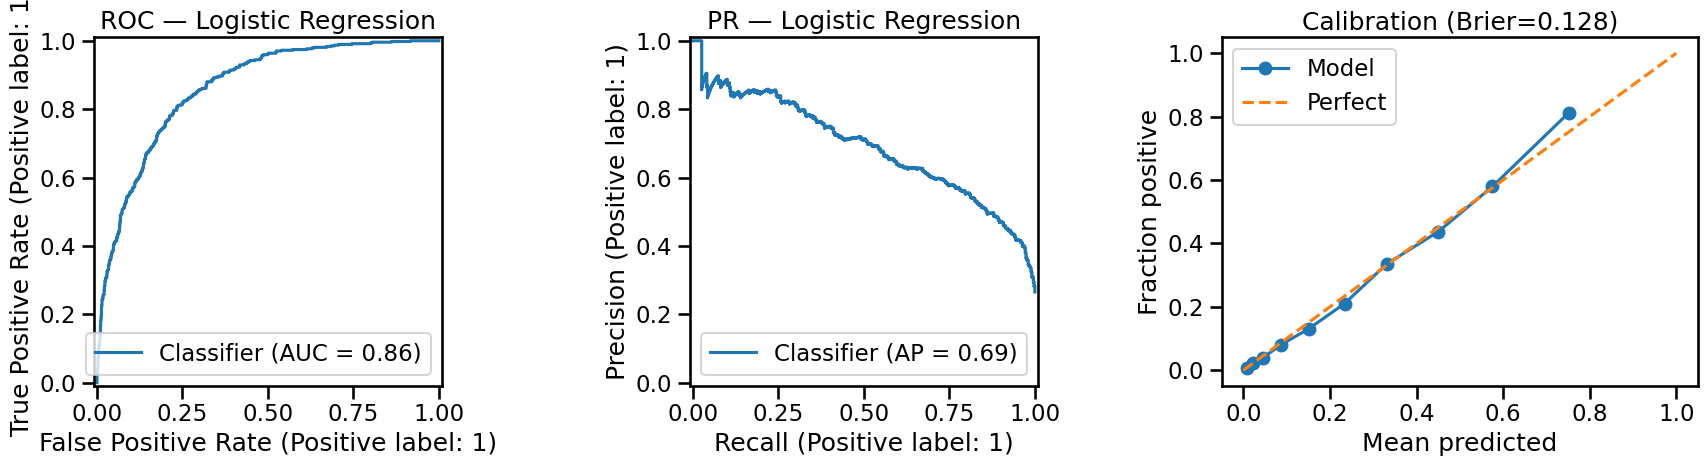

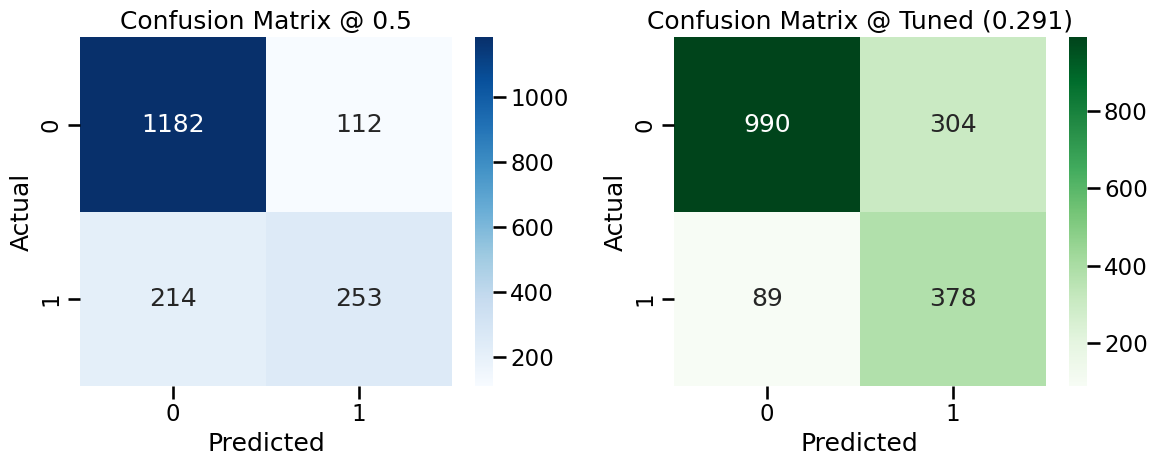

In [110]:
# Diagnostics: ROC, PR, Calibration curves & confusion matrices
fig, axes = plt.subplots(1,3, figsize=(18,5))
RocCurveDisplay.from_predictions(y_test, proba, ax=axes[0]); axes[0].set_title('ROC — Logistic Regression')
PrecisionRecallDisplay.from_predictions(y_test, proba, ax=axes[1]); axes[1].set_title('PR — Logistic Regression')
axes[2].plot(mean_pred, frac_pos, marker='o', label='Model'); axes[2].plot([0,1],[0,1],'--', label='Perfect')
axes[2].set_title(f'Calibration (Brier={brier:.3f})'); axes[2].set_xlabel('Mean predicted'); axes[2].set_ylabel('Fraction positive'); axes[2].legend()
plt.tight_layout(); plt.show()

import seaborn as sns
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, pred05), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix @ 0.5'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
sns.heatmap(confusion_matrix(y_test, pred_tuned), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Confusion Matrix @ Tuned ({best_thr:.3f})'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
plt.tight_layout(); plt.show()

### Diagnostics Summary
- The model provides reliable risk scores that separate churners from non-churners, and a tuned threshold boosts recall to better guide retention actions.



## Risk Tiering (Deciles of Predicted Risk)

  risk_decile  customers  lapsers  lapse_rate  avg_proba  rank
0          D1        177        1    0.005650   0.007492     1
1          D2        176        4    0.022727   0.021179     2
2          D3        176        7    0.039773   0.045555     3
3          D4        176       14    0.079545   0.085894     4
4          D5        176       23    0.130682   0.150850     5
5          D6        176       37    0.210227   0.233755     6
6          D7        176       59    0.335227   0.331037     7
7          D8        176       77    0.437500   0.450601     8
8          D9        176      102    0.579545   0.575386     9
9         D10        176      143    0.812500   0.751892    10


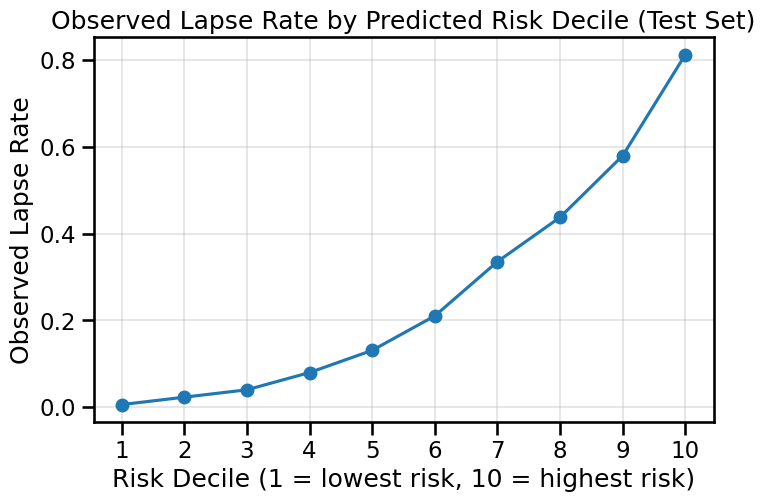

{'capture_rate_of_all_lapsers_in_top_decile': 0.306, 'precision_in_top_decile': 0.812}


In [113]:
# Compute risk deciles on test set and show lapse rate by decile
test_df = X_test.copy()
test_df['y_true'] = y_test.values
test_df['proba'] = proba

# Decile 10 = highest risk
test_df['risk_decile'] = pd.qcut(test_df['proba'], q=10, labels=[f'D{i}' for i in range(1,11)])
decile_summary = test_df.groupby('risk_decile').agg(
    customers=('y_true','size'),
    lapsers=('y_true','sum'),
    lapse_rate=('y_true','mean'),
    avg_proba=('proba','mean')
).reset_index()
decile_summary = decile_summary.sort_values('risk_decile')

# Sort by avg_proba to rank properly (ensure D10 highest)
decile_summary = decile_summary.sort_values('avg_proba')
decile_summary['rank'] = range(1, len(decile_summary)+1)
decile_summary = decile_summary.sort_values('rank')

print(decile_summary)

# Visualize lapse rate by risk decile
plt.figure(figsize=(8,5))
plt.plot(decile_summary['rank'], decile_summary['lapse_rate'], marker='o')
plt.title('Observed Lapse Rate by Predicted Risk Decile (Test Set)')
plt.xlabel('Risk Decile (1 = lowest risk, 10 = highest risk)')
plt.ylabel('Observed Lapse Rate')
plt.xticks(decile_summary['rank'])
plt.grid(True, alpha=0.3)
plt.show()

# Show top decile capture (how many lapsers are in the highest-risk 10%)
top_decile = test_df.nlargest(int(0.10 * len(test_df)), 'proba')
capture_rate = top_decile['y_true'].sum() / test_df['y_true'].sum()
precision_top_decile = top_decile['y_true'].mean()
print({'capture_rate_of_all_lapsers_in_top_decile': round(capture_rate,3),
       'precision_in_top_decile': round(precision_top_decile,3)})

### Risk Decile Summary

Churn risk is well-stratified: lapse rates rise steadily across deciles, and the top 10% of customers contain a large share of actual churners, making them an effective high-priority segment for retention campaigns. Specifically:

 - Lowest decile (D1) shows only 0.6% lapse rate.
 - Highest decile (D10) shows 81% lapse rate.
 - Lapse rate climbs steadily across deciles (from ~1% → 81%).
 - The top decile (10% of customers) alone contains 143 churners (~32% of all lapsers), making it the most effective target group for retention efforts.

### Final Note

While this Telco Churn dataset is a common teaching tool, I believe that:
 - Applying it in this risk-tiered lapse analysis is non-standard and shows clear value for life insurance lapse-sensitive products.
 - It demonstrates how predictive modeling can be repurposed to highlight high-risk segments and guide targeted retention strategies in real business contexts.